In [1]:
import gzip
import operator as op
from collections import Counter
from itertools import chain, groupby, takewhile
from typing import Optional, Callable, Tuple, List
from concurrent.futures import ThreadPoolExecutor

import regex as re
import numpy as np
import seaborn as sns
import tqdm
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_rna, generic_dna
from Bio.SeqRecord import SeqRecord
from fn import F

sns.set(color_codes=True)

%matplotlib inline

Region extraction utilities

In [2]:
ALPHABET = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'T': 'T',
    'R': '[AG]',
    'Y': '[CT]',
    'S': '[GC]',
    'W': '[AT]',
    'K': '[GT]',
    'M': '[AC]',
    'B': '[CGT]',
    'D': '[AGT]',
    'H': '[ACT]',
    'V': '[ACG]',
    'N': '[ACGT]'
}

Primer = Callable[[str], Optional[Tuple[int, int]]]


def mkprimer(substitutions: int, primer_sequence: str) -> Primer:
    """
    Create a universal primer.
    :param substitutions: the number of allowed mismatches
    :param primer: An IUPAC-encoded primer sequence
    :return: A callable that searches for the first occurrence of the primer
             in a sequence and returns it's span (if found).
    :raises ValueError: primer sequence contains non-IUPAC DNA characters.  
    """
    try:
        base = ''.join(ALPHABET[base] for base in primer_sequence)
        fuzzy = f'{{s<={substitutions}}}' if substitutions else ''
        pattern = re.compile(f'(:?{base}){fuzzy}', flags=re.BESTMATCH)
    except KeyError as err:
        raise ValueError(f'unknown base: {err}')
    
    def primer(sequence: str) -> Optional[Tuple[int, int]]:
        match = pattern.search(sequence)
        return match.span() if match else None
    
    return primer


def extract_region(forward: Primer, reverse: Primer, seqrec: SeqRecord) -> Optional[SeqRecord]:
    """
    Extract a region flanked by the primers 
    """
    try:
        _, start = forward(str(seqrec.seq))
        end, _ = reverse(str(seqrec.seq))
    except TypeError: # can't find primers
        return None
    return seqrec[start:end]


# Standard 16S rRNA V4-region forward and reverse universal primers; allow up to 2 mismatches
fwd_primer = mkprimer(2, 'GTGCCAGCMGCCGCGGTAA')
rev_primer = mkprimer(2, str(Seq('GGACTACVSGGGTATCTAAT', generic_dna).reverse_complement()))

Read sequences, discard short records, extract V4 regions, discard failed records, parse taxonomy

In [3]:
def back_transcribe(seqrec: SeqRecord) -> SeqRecord:
    """
    Back-transcribe an RNA sequence record
    """
    return SeqRecord(id=seqrec.id, name=seqrec.name, description=seqrec.description,
                     seq=seqrec.seq.back_transcribe())

def parse_taxonomy(seqrec: SeqRecord) -> List[str]:
    """
    Parse taxonomy from SILVA sequence records
    """
    return seqrec.description.split(' ', 1)[1].split(';')


with gzip.open('taxonomy/SILVA_132_SSURef_tax_silva_trunc.fasta.gz', 'rt') as silva_buffer:
    with ThreadPoolExecutor(4) as workers:
        silva_seqs = (
            F(filter, lambda seqrec: 1100 <= len(seqrec) <= 1600) >>
            (map, back_transcribe) >> 
            (workers.map, F(extract_region, fwd_primer, rev_primer)) >> 
            (filter, bool) >> 
            list
        )(SeqIO.parse(silva_buffer, 'fasta'))
        silva_taxa = list(map(parse_taxonomy, silva_seqs))

Plot sequence length distribution

/opt/anaconda/envs/students/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(100, 400)]

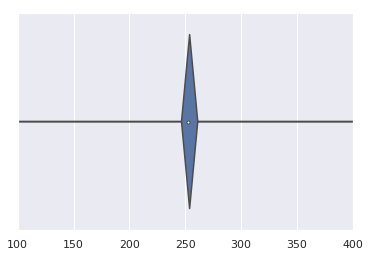

In [4]:
sns.violinplot(
    [len(seqrec) for seqrec, tax in zip(silva_seqs, silva_taxa)]
).set(xlim=(100, 400))

Analyse taxonomy label distributions at all rank levels

Filter taxonomy. We've analysed the distributions of taxa labels at all levels and have found out that labels starting with lower-case words and labels containig the substring "sp." almost exclusively correspond to unclassified isolates. Remove remaining eukaryotes (theoretically, they should've been discarded at the V4-extraction phase due to primer mismatch).

In [5]:
def filter_taxonomy(rule: Callable[[str], bool], taxonomy: List[str]) -> List[str]:
    """
    Truncate taxonomies at first occurence of "bad" labels
    :param rule: a label validation rule; good labels should evaluate as True
    """
    ranks = (rank if rule(rank) else None for rank in taxonomy)
    return list(takewhile(bool, ranks))


good_label_rule = lambda rank: not (rank.split()[0].islower() or 'sp.' in rank)

silva_seqs_noneuk, silva_taxa_noneuk_transformed = zip(*[
    (seqrec, filter_taxonomy(good_label_rule, tax)) 
    for seqrec, tax in zip(silva_seqs, silva_taxa) if not tax[0].startswith('Euk')
])
f'Picked {len(silva_seqs_noneuk)} sequences out of {len(silva_seqs)}'

'Picked 1865548 sequences out of 1866614'

Remove sequences lacking genus-level annotation and replace missing species annotations with f'unclassified {genus} isolate'

In [6]:
silva_seqs_withgen, silva_taxa_withgen = zip(*[
    (seqrec, (*tax, f'unclassified {tax[-1]} isolate')[:7]) 
    for seqrec, tax in zip(silva_seqs_noneuk, silva_taxa_noneuk_transformed) if len(tax) >= 6
])

Sanity check the most common species labels

In [7]:
species = (F(map, op.itemgetter(6)) >> Counter >> Counter.most_common)(silva_taxa_withgen)
species[:50]

[('unclassified Staphylococcus isolate', 116764),
 ('unclassified Corynebacterium 1 isolate', 61262),
 ('unclassified Cutibacterium isolate', 58012),
 ('unclassified Streptococcus isolate', 55916),
 ('unclassified Bacteroides isolate', 36719),
 ('unclassified Pseudomonas isolate', 32403),
 ('unclassified Bacillus isolate', 24142),
 ('unclassified WCHB1-32 isolate', 15526),
 ('unclassified Escherichia-Shigella isolate', 15243),
 ('unclassified Lactobacillus isolate', 13841),
 ('unclassified Acinetobacter isolate', 13690),
 ('unclassified Streptomyces isolate', 11834),
 ('unclassified Faecalibacterium isolate', 11016),
 ('unclassified Salmonella isolate', 10010),
 ('unclassified Lachnospiraceae NK4A136 group isolate', 9426),
 ('unclassified Blautia isolate', 9370),
 ('unclassified Burkholderia-Caballeronia-Paraburkholderia isolate', 8678),
 ('unclassified Cloacibacterium isolate', 8154),
 ('unclassified Neisseria isolate', 8072),
 ('unclassified Haemophilus isolate', 7969),
 ('unclassifi

Export results grouped by taxonomy

In [8]:
trainset = [
    SeqRecord(id=';'.join(['Root', *tax]), name='', description='', seq=seqrec.seq)
    for seqrec, tax in zip(silva_seqs_withgen, silva_taxa_withgen)
]
taxgroups = groupby(sorted(trainset, key=lambda x: x.id), lambda x: x.id)

! mkdir -p taxonomy/groups

for i, (_, group) in tqdm.tqdm(enumerate(taxgroups, 1)):
    with open(f'taxonomy/groups/group{i}.fna', 'w') as groupout:
        SeqIO.write(group, groupout, 'fasta')

51363it [00:18, 2743.42it/s]
